<a href="https://colab.research.google.com/github/AngelV404/CreditRiskAssessment/blob/main/CreditRiskAssessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc


In [7]:
# Load the dataset
data = pd.read_csv('/content/sample_data/credit_risk_dataset_2.csv')  # Adjust the path to your dataset


In [8]:
# Define categorical and numerical features
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# Preprocessing steps for pipeline
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', num_imputer), ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[('imputer', cat_imputer), ('encoder', OneHotEncoder())]), categorical_features)
    ])

# Create a logistic regression pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=300))
])


In [9]:
# Split the data
X = data.drop('loan_status', axis=1)
y = data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('classifier', LogisticRegression(max_iter=300))])

In [10]:
# Predict on the test data
y_pred = pipeline.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("ROC-AUC Score:", roc_auc)
print("Classification Report:\n", classification_rep)


ROC-AUC Score: 0.7496970953903921
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      5072
           1       0.77      0.55      0.64      1445

    accuracy                           0.86      6517
   macro avg       0.82      0.75      0.78      6517
weighted avg       0.86      0.86      0.85      6517



In [11]:
# Feature importance extraction correction
if 'LogisticRegression' in [type(est).__name__ for est in pipeline.named_steps.values()]:
    # Corrected access to OneHotEncoder for categorical feature names
    categorical_transformer = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
    categorical_features_encoded = categorical_transformer.get_feature_names_out(categorical_features)
    feature_names = np.concatenate((numerical_features, categorical_features_encoded))

    # Get coefficients from the classifier
    coefs = pipeline.named_steps['classifier'].coef_[0]

    # Create DataFrame of features and their importance
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefs})
    print("Feature Importance:\n", feature_importance.sort_values(by='Importance', ascending=False))

Feature Importance:
                            Feature  Importance
23                    loan_grade_G    3.074064
5              loan_percent_income    1.419426
22                    loan_grade_F    1.202587
10      person_home_ownership_RENT    0.934959
21                    loan_grade_E    0.671247
8      person_home_ownership_OTHER    0.510091
20                    loan_grade_D    0.506277
13     loan_intent_HOMEIMPROVEMENT    0.488200
11   loan_intent_DEBTCONSOLIDATION    0.457603
14             loan_intent_MEDICAL    0.257223
4                    loan_int_rate    0.167840
7   person_home_ownership_MORTGAGE    0.075610
1                    person_income    0.052054
6       cb_person_cred_hist_length    0.022819
25     cb_person_default_on_file_Y    0.004659
24     cb_person_default_on_file_N   -0.012565
0                       person_age   -0.044245
2                person_emp_length   -0.045280
15            loan_intent_PERSONAL   -0.158453
12           loan_intent_EDUCATION   -0

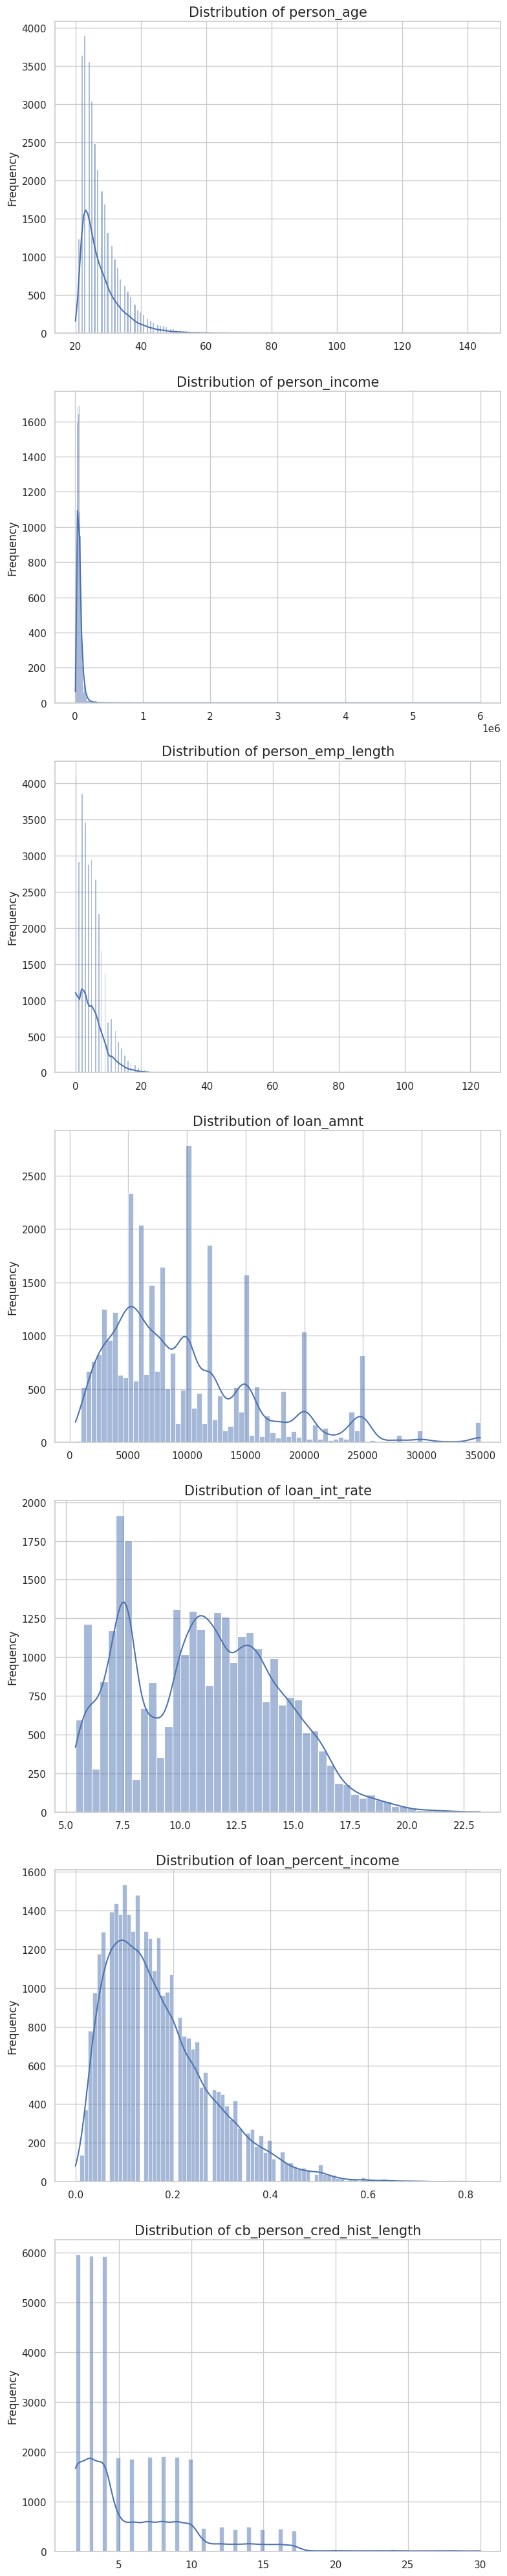

In [12]:
# Visualizing Data Distributions
# Set up the aesthetics for plots
sns.set(style="whitegrid")

# Histograms for numerical features
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
fig, axes = plt.subplots(nrows=len(numerical_features), figsize=(8, 40))

for i, col in enumerate(numerical_features):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=15)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

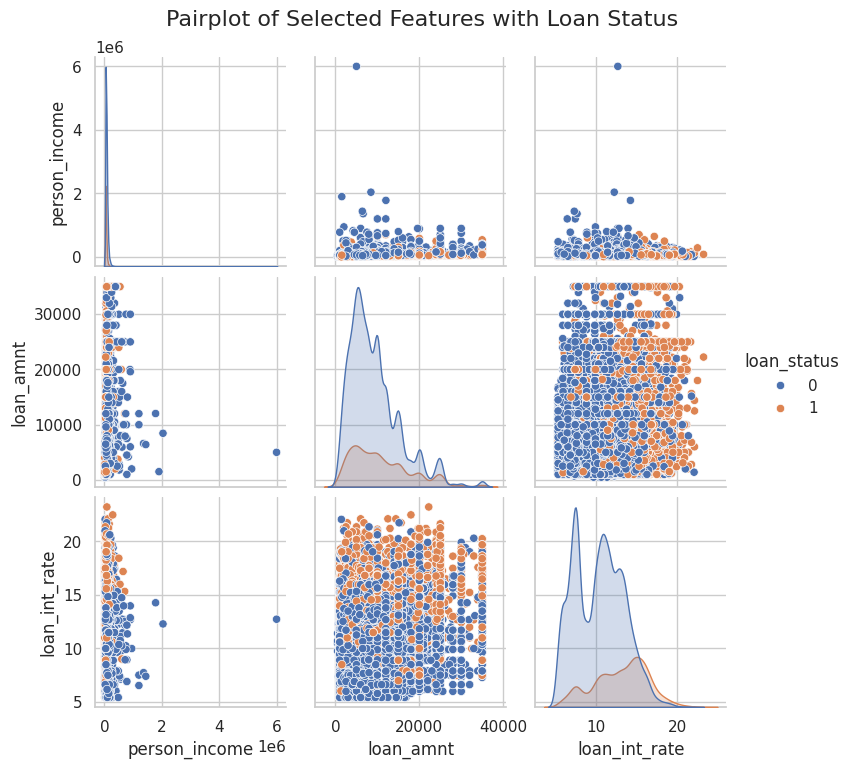

In [13]:
# Pairplot for a subset of features to see interactions
subset_features = ['person_income', 'loan_amnt', 'loan_int_rate', 'loan_status']
sns.pairplot(data[subset_features], hue='loan_status', height=2.5)
plt.suptitle('Pairplot of Selected Features with Loan Status', size=16, y=1.02)
plt.show()

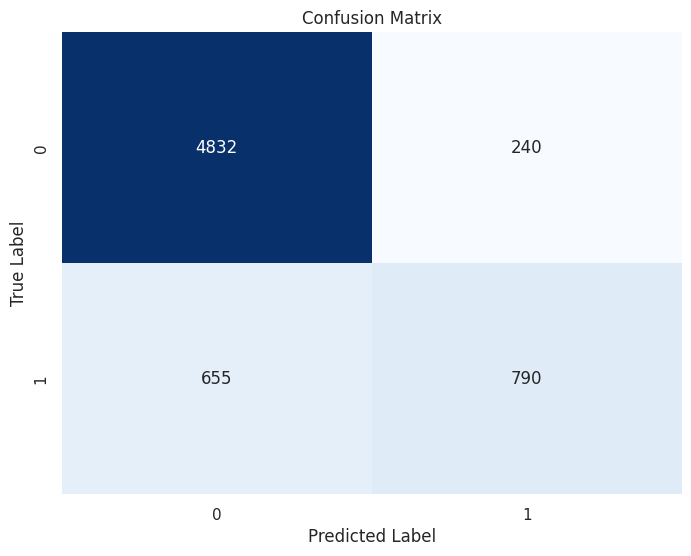

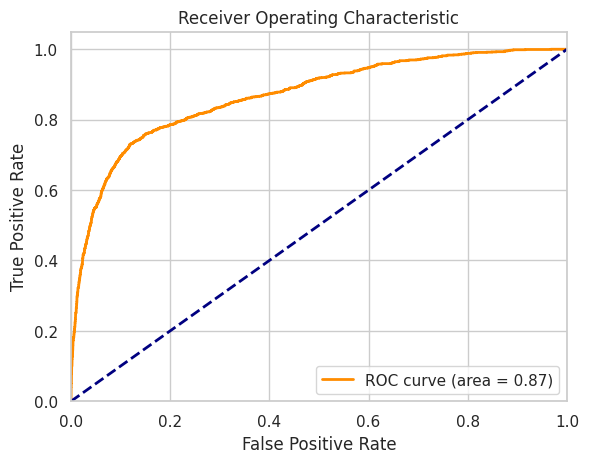

In [14]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
